In [3]:

import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,auc
from app.preprocessing import clean_text

data = pd.read_csv("C:/Users/avani/OneDrive/Desktop/Fake_News/data/WELFake_Dataset.csv")
df = pd.DataFrame(data)





In [4]:
df = df.fillna("")

In [5]:
df["news_content"] = df["title"].astype(str) + " " + df["text"].astype(str)


In [6]:
df["clean_text"] = df["news_content"].apply(clean_text)

x = df["clean_text"]
y = df["label"] 

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=5000)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
pickle.dump(vectorizer, open("models/vectorizer.pkl", "wb"))




In [7]:
# Logistic Regression
lr = LogisticRegression()
model_lr = lr.fit(x_train_vec, y_train)
y_pred_lr = model_lr.predict(x_test_vec)
acc_lr = accuracy_score(y_test,y_pred_lr)

pickle.dump(lr, open("models/model_lr.pkl", "wb"))

# Multinomial Naive Bayes
mnb = MultinomialNB()
model_mnb = mnb.fit(x_train_vec, y_train)
y_pred_mnb = model_mnb.predict(x_test_vec)
acc_mnb = accuracy_score(y_test,y_pred_mnb)

pickle.dump(mnb, open("models/model_mnb.pkl", "wb"))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb = xgb.fit(x_train_vec, y_train)
y_pred_xgb = model_xgb.predict(x_test_vec)
acc_xgb = accuracy_score(y_test,y_pred_xgb)

pickle.dump(xgb, open("models/model_xgb.pkl", "wb"))





c:\Users\avani\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:36:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


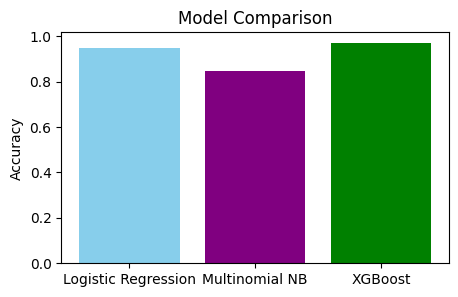

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.bar(["Logistic Regression", "Multinomial NB","XGBoost"], [acc_lr, acc_mnb,acc_xgb],color = ["skyblue","purple","green"])
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.savefig("C:/Users/avani/OneDrive/Desktop/Fake_News/plots/accuracy_comparison.png")
plt.show()

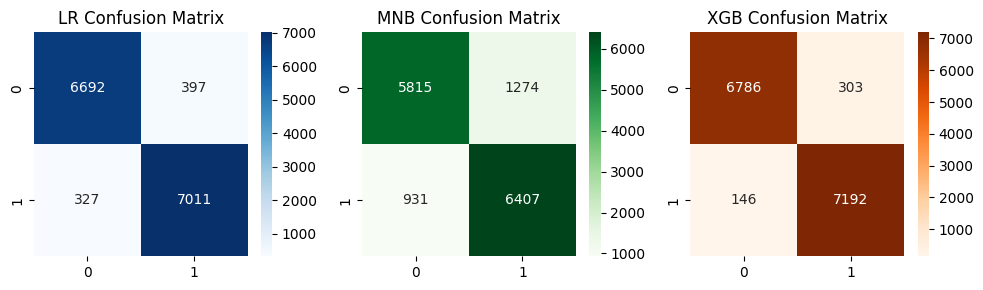

In [9]:
import seaborn as sns
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_mnb = confusion_matrix(y_test, y_pred_mnb) 
cm_xgb = confusion_matrix(y_test, y_pred_xgb) 

plt.figure(figsize=(10,3))

plt.subplot(1,3,1)
sns.heatmap(cm_lr, annot=True, fmt='g',cmap="Blues")
plt.title("LR Confusion Matrix")

plt.subplot(1,3,2)
sns.heatmap(cm_mnb, annot=True, fmt='g',cmap="Greens")
plt.title("MNB Confusion Matrix")

plt.subplot(1,3,3)
sns.heatmap(cm_xgb, annot=True, fmt='g',cmap="Oranges")
plt.title("XGB Confusion Matrix")

plt.tight_layout()

plt.savefig("C:/Users/avani/OneDrive/Desktop/Fake_News/plots/confusion_matrices.png")
plt.show()


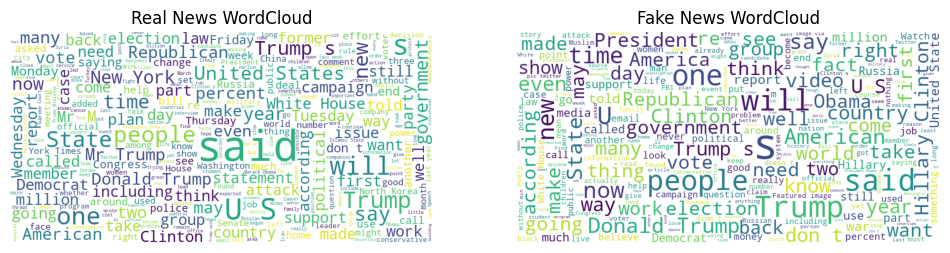

In [10]:
from wordcloud import WordCloud, STOPWORDS

real_text = " ".join(df[df["label"] == 0]["news_content"][:2000])
fake_text = " ".join(df[df["label"] == 1]["news_content"][:2000])

wc = WordCloud(
    background_color="white",
    max_words=300,         
    width=800,
    height=400,
    stopwords=STOPWORDS , 
    max_font_size= 80,
    min_font_size=6   
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(wc.generate(real_text))
plt.title("Real News WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc.generate(fake_text))
plt.title("Fake News WordCloud")
plt.axis("off")

plt.savefig("C:/Users/avani/OneDrive/Desktop/Fake_News/plots/wordcloud.png")

plt.show()


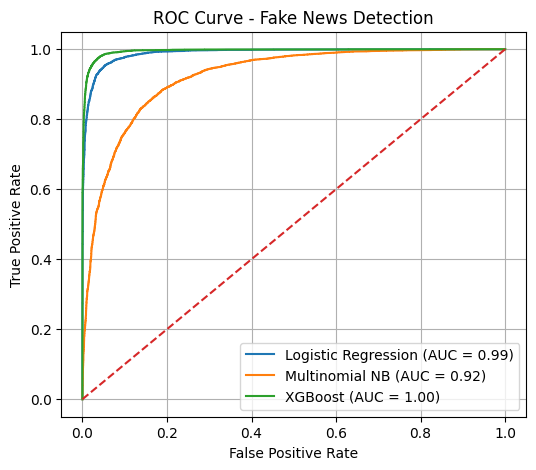

In [11]:
y_prob_lr = lr.predict_proba(x_test_vec)[:, 1]
y_prob_mnb = mnb.predict_proba(x_test_vec)[:, 1]
y_prob_xgb = xgb.predict_proba(x_test_vec)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, y_prob_mnb)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

auc_lr = auc(fpr_lr, tpr_lr)
auc_mnb = auc(fpr_mnb, tpr_mnb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(6,5))

plt.plot(
    fpr_lr,
    tpr_lr,
    label=f"Logistic Regression (AUC = {auc_lr:.2f})"
)

plt.plot(
    fpr_mnb,
    tpr_mnb,
    label=f"Multinomial NB (AUC = {auc_mnb:.2f})"
)

plt.plot(
    fpr_xgb,
    tpr_xgb,
    label=f"XGBoost (AUC = {auc_xgb:.2f})"
)
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fake News Detection")
plt.legend()
plt.grid()

plt.savefig("C:/Users/avani/OneDrive/Desktop/Fake_News/plots/roc_curve.png")

plt.show()
